<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

## San Francisco Data

---

[San Francisco provides a wealth of data on the city to the public.](https://data.sfgov.org/) 

Project 3 is all about modelling exploring this data and modeling interesting relationships with regression. 


---

## Notes on the data

We have gone through the above website and pulled out a variety of different datasets that we think are particularly interesting. Some of the datasets are from external sources as well, but all are related to San Francisco. A high level overview of data folders is provided after the project requirements section.

** Feel free to include any other datasets from the San Francisco data if you think there is relevance or if it could be useful for your analysis.**


**The uncompressed data is a large filesize.** Even the compressed data is pretty large. The data is compressed into a .7z format which has one of the smallest filesizes available. You will likely need a 3rd party app to extract it. 

### Recommended Utilities for .7z
- For OSX [Keka](http://www.kekaosx.com/en/) or [The Unarchiver](http://wakaba.c3.cx/s/apps/unarchiver.html). 
- For Windows [7-zip](http://www.7-zip.org/) is the standard. 
- For Linux try the `p7zip` utility.  `sudo apt-get install p7zip`.

---

## Project requirements

**You will be performing 4 different sections of analysis on the San Francisco data.**

**Models must be regression. This means that your target variable needs to be numeric/continuous**

Do not perform classification models – this will be the topic of week 4.


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 1. Use the San Francisco assessor dataset and perform EDA

---

1. Explain what the data is. This may include multiple csv files. Some of this data has hard to understand codes representing the variables. Nearly all data is pulled from https://data.sfgov.org/ so this is a very good resource for determining what the data is.
- Clean the data.
- Develop and state clearly a hypothesis about the data that you would want to test.(This is totally upto you)
- Create some initial visualizations on the portions of the data relevant to your hypothesis.

In [107]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
import patsy
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn import metrics
sns.set_style('white')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(rc={"figure.figsize": (12, 12)})

In [7]:
ass = pd.read_csv('~/Desktop/gzdsi7/datasets/sf_assessor_value/assessor_value_cleaned.csv')
ass_key = pd.read_csv('~/Desktop/gzdsi7/datasets/san_fran/assessor_office/assessor_neighborhood_key.csv')

In [8]:
ass_key.head()

,DISTRICT,CODE,NEIGHBORHOOD,BOUNDRIES
0,1,1A,Central Richmond,"South of California, Park Presidio, south of F..."
1,1,1B,Inner Richmond,"South of California, Arguello, south of Fulton..."
2,1,1C,Jordan Park/Laurel Heights,"California, west of Presidio, Geary, Arguello"
3,1,1D,Lake --The Presidio,"West and south of Presidio Terrace, Arguello, ..."
4,1,1E,Outer Richmond,"The Ocean, west of 32nd Avenue, south of Fulton"


In [9]:
del ass_key['DISTRICT']

In [10]:
del ass_key['BOUNDRIES']

In [11]:
for i, code in enumerate(ass_key.CODE.values):
    if len(code) < 3:
        ass_key.CODE[i] = "0"+ass_key.CODE[i]

In [12]:
ass['neighborhood'].replace(ass_key.set_index('CODE')['NEIGHBORHOOD'], inplace=True)

In [13]:
ass.head()

,baths,beds,lot_depth,basement_area,front_ft,owner_pct,rooms,property_class,neighborhood,tax_rate,volume,sqft,stories,year_recorded,year_built,zone,value
0,2,2,0.0,0.0,0.0,1.00000,5,Z,Russian Hill,1000.0,1,1419,0,2007,1907,RH3,1002840.0
1,2,2,0.0,0.0,0.0,1.00000,7,Z,Russian Hill,1000.0,1,1773,0,2007,1907,RH3,1433430.0
2,2,2,0.0,0.0,0.0,1.00000,5,Z,Russian Hill,1000.0,1,1242,0,2007,1995,C2,485599.0
3,1,0,0.0,0.0,0.0,0.33333,6,D,Russian Hill,1000.0,1,1820,1,2007,1927,RH3,120826.0
4,1,0,0.0,0.0,0.0,1.00000,4,D,Russian Hill,1000.0,1,1020,1,2007,1926,RH3,988380.0


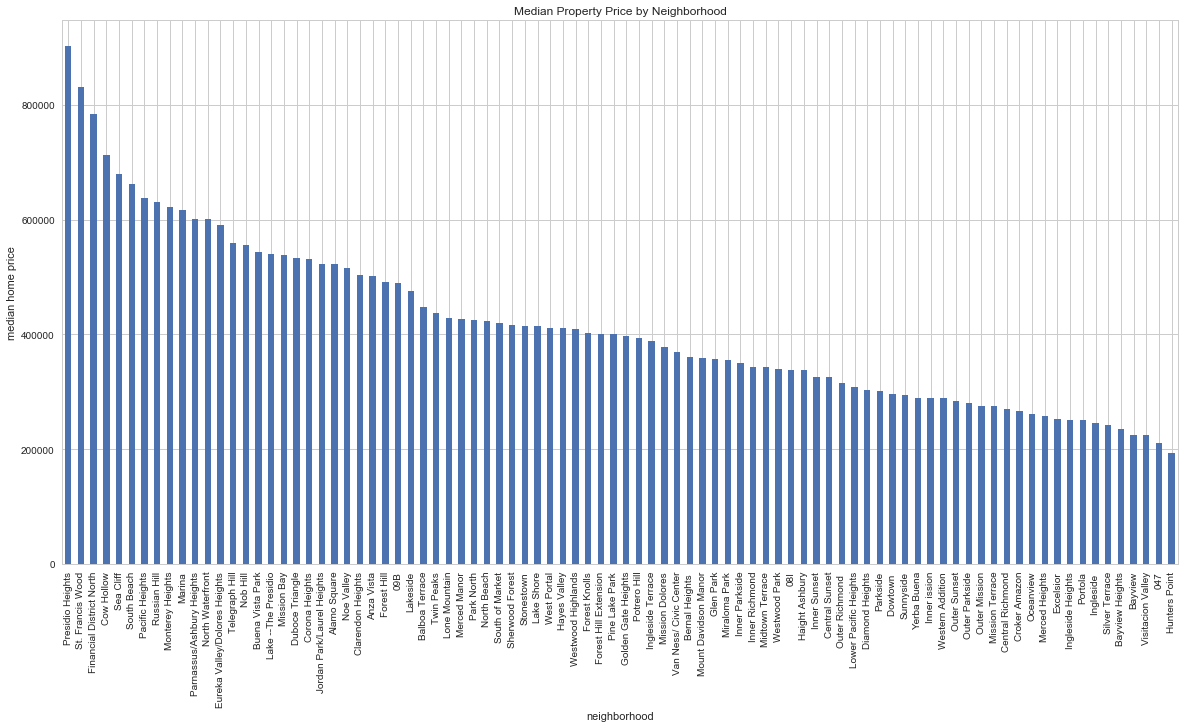

In [17]:
plt.figure(figsize=(20,10))
plt.ylabel('median home price')
plt.title('Median Property Price by Neighborhood')
ass.groupby(['neighborhood'])['value'].median().sort_values(ascending=False).plot(kind='bar')

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 2. Construct and evaluate a linear regression model on the data

---

1. State the variables that are predictors in your linear regression and the target variable.
- Investigate and remove any outliers or other problems in your data. _This is a subjective process._
- Construct a linear regression model.
- Evaluate the model. How does the $R^2$ of the overall model compare to cross-validated $R^2$. What do the differences in $R^2$ mean?
  - Use test / train split
  - Use K-Folds
  - Compare and explain your results with both
- Visualize the evaluation metrics of your analysis in clear charts.
- Summarize your results in the context of your hypothesis. Frame this as if you are presenting to non-technical readers.


In [21]:
nb_dum = pd.get_dummies(ass['neighborhood'])

In [22]:
sf = pd.concat([ass, nb_dum], axis=1)

In [23]:
y = sf['value']

In [24]:
X = pd.concat([sf.iloc[:,18:], sf[['sqft','year_built', 'beds' ]]], axis=1)

In [25]:
del X['09B']
del X['08I']

In [28]:
lr = LinearRegression()
lr_scores = cross_val_score(lr, X, y, cv=10, scoring = 'neg_mean_squared_error')
print lr_scores

[ -9.61893002e+10  -1.08266741e+11  -9.85415160e+10  -1.06784918e+11
  -7.51561364e+10  -1.05843515e+11  -1.12583946e+11  -9.83230197e+10
  -1.19255060e+11  -8.91605538e+10]


In [30]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5,shuffle=True)
for train, test in kfold.split(X,y):
    Xtrain, ytrain = X.loc[train], y[train]
    Xtest, ytest = X.loc[test], y[test]
    lr = LinearRegression()
    lr.fit(Xtrain,ytrain)
    
    print lr.score(Xtest, ytest), lr.score(Xtrain,ytrain)

0.257553617402 0.255404614339
0.26010245107 0.254785082468
0.251094422335 0.257039472819
0.254976405161 0.256063636478
0.254389356561 0.256201178273


In [31]:
lr.fit(X, y)
r_squared = lr.score(X,y)
print "R2", r_squared

R2 0.255872276728


<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 2.2 Explain $R^2$ vs. mean squared error (MSE)

---

1. If you have negative $R^2$ values in cross-validation, what does this mean? 
2. Why can $R^2$ only be negative when the model is tested on new data?

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 3. Combine Crime and Fire incidents datasets from the  San Francisco data. Build a Linear regression model to predict number of fire incidents. What are the most significant predictors?

### Evaluate the model with regularized regression.

---

**I recommend having many predictors to see benefits from regularization methods, but it's up to you.**


- Like in part 1, you should state a hypothesis and perform data cleaning and EDA _only_ on the relevant portions of your data. Don't waste time!
- Construct and evaluate different models with cross-validated $R^2$. Compare LinearRegression, Lasso, Ridge, and ElasticNet. 
- Report on which model is best after performing regularization, and why that might be the case (hint: does your data have multicollinearity? Irrelevant variables? Both?)
- Plot visuals that compare the performance of the four models.


In [393]:
fire = pd.read_csv('/Users/Gene/Desktop/gzdsi7/datasets/san_fran/fire_data/fire_incidents.csv')
crime = pd.read_csv('/Users/Gene/Desktop/gzdsi7/datasets/san_fran/sf_crime/sfpd_incidents_from2003.csv')

In [394]:
fire_sample = fire.sample(frac = .05)
crime_sample = crime.sample(frac = .05)

In [395]:
fire_sample['date'] = pd.to_datetime(fire_sample['Incident Date'])

In [396]:
crime_sample['date'] = pd.to_datetime(crime_sample['Date'])

In [401]:
fire_sample.isnull().sum().sort_values(ascending=False) / fire_sample.shape[0]

Number of Alarms                                1.000000
Number of floors with minimum damage            0.983380
Number of floors with extreme damage            0.983380
Number of floors with significant damage        0.983331
Number of floors with heavy damage              0.983331
Number of Sprinkler Heads Operating             0.983183
Floor of Fire Origin                            0.981217
Automatic Extinguishing Sytem Failure Reason    0.976447
Fire Spread                                     0.976398
Detector Failure Reason                         0.976398
Automatic Extinguishing Sytem Type              0.976103
Automatic Extinguishing Sytem Perfomance        0.976103
Detector Effectiveness                          0.975955
Detector Operation                              0.975414
Detector Type                                   0.975414
Structure Status                                0.974283
Automatic Extinguishing System Present          0.974283
Detectors Present              

In [392]:
pd.pivot_table()

,Incident Number,Exposure Number,Address,Incident Date,Call Number,Alarm DtTm,Arrival DtTm,Close DtTm,City,Zipcode,...,Detector Failure Reason,Automatic Extinguishing System Present,Automatic Extinguishing Sytem Type,Automatic Extinguishing Sytem Perfomance,Automatic Extinguishing Sytem Failure Reason,Number of Sprinkler Heads Operating,Supervisor District,Neighborhood District,Location,date
30419,3010439,0,21st Av. / Geary Bl.,02/06/2003,30370017,02/06/2003 01:52:15 AM,02/06/2003 01:55:22 AM,02/06/2003 01:55:42 AM,SF,94121.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Outer Richmond,"(37.7802790000296, -122.480452)",2003-02-06
208813,9023258,0,1510 Eddy St.,03/20/2009,90790227,03/20/2009 01:51:04 PM,03/20/2009 01:56:03 PM,03/20/2009 02:03:13 PM,SF,94115.0,...,-,-,-,-,-,NaN,5.0,Western Addition,"(37.7814670000297, -122.432579)",2009-03-20
340713,15032443,0,450 Powell Street,03/26/2015,150851955,03/26/2015 01:37:13 PM,03/26/2015 01:40:11 PM,03/26/2015 01:48:52 PM,San Francisco,94108.0,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,Financial District/South Beach,"(37.7889840000297, -122.408226)",2015-03-26
42291,3084822,0,101 2nd St.,10/23/2003,32960001,10/23/2003 12:03:53 AM,10/23/2003 12:04:15 AM,10/23/2003 12:07:48 AM,SF,94105.0,...,NaN,NaN,NaN,NaN,NaN,NaN,6.0,Financial District/South Beach,"(37.7880070000297, -122.39968)",2003-10-23
176393,3072162,0,2 Harrison St.,09/09/2003,32520321,09/09/2003 06:00:46 PM,09/09/2003 06:01:49 PM,09/09/2003 06:29:31 PM,SF,94105.0,...,NaN,NaN,NaN,NaN,NaN,NaN,6.0,Financial District/South Beach,"(37.7895740000297, -122.388608)",2003-09-09
252841,9068475,0,255 Red Rock Wy.,08/19/2009,92310068,08/19/2009 07:08:34 AM,08/19/2009 07:15:50 AM,08/19/2009 07:20:34 AM,SF,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-08-19
115991,10109685,0,6th St. / Townsend St.,12/08/2010,103420435,12/08/2010 11:18:59 PM,12/08/2010 11:22:45 PM,12/08/2010 11:22:58 PM,SF,94107.0,...,NaN,NaN,NaN,NaN,NaN,NaN,6.0,South of Market,"(37.7735750000297, -122.399437)",2010-12-08
85512,9064541,0,600 16th St.,08/05/2009,92170337,08/05/2009 08:19:22 PM,08/05/2009 08:26:03 PM,08/05/2009 08:35:03 PM,SF,94158.0,...,NaN,NaN,NaN,NaN,NaN,NaN,6.0,Mission Bay,"(37.7674660000297, -122.39086)",2009-08-05
57384,13070947,0,Folsom St / 20th St,07/29/2013,132100096,07/29/2013 08:07:06 AM,07/29/2013 08:11:26 AM,07/29/2013 08:11:41 AM,SF,94110.0,...,NaN,NaN,NaN,NaN,NaN,NaN,9.0,Mission,"(37.7588960000297, -122.414693)",2013-07-29
382366,14067115,0,699 Market Street,07/12/2014,141933464,07/12/2014 11:15:49 PM,07/12/2014 11:20:56 PM,07/12/2014 11:21:34 PM,San Francisco,94105.0,...,NaN,NaN,NaN,NaN,NaN,NaN,6.0,Financial District/South Beach,"(37.7876430000297, -122.403311)",2014-07-12


In [96]:
pd.merge(fire_sample,crime_sample, on = 'date')

,Incident Number,Exposure Number,Address_x,Incident Date,Call Number,Alarm DtTm,Arrival DtTm,Close DtTm,City,Zipcode,...,DayOfWeek,Date,Time,PdDistrict,Resolution,Address_y,X,Y,Location_y,PdId
0,3010439,0,21st Av. / Geary Bl.,02/06/2003,30370017,02/06/2003 01:52:15 AM,02/06/2003 01:55:22 AM,02/06/2003 01:55:42 AM,SF,94121.0,...,Thursday,02/06/2003,07:33,BAYVIEW,"ARREST, BOOKED",0 Block of WESTBROOK CT,-122.382453,37.734930,"(37.7349303029099, -122.382452903681)",3015178616010
1,3010439,0,21st Av. / Geary Bl.,02/06/2003,30370017,02/06/2003 01:52:15 AM,02/06/2003 01:55:22 AM,02/06/2003 01:55:42 AM,SF,94121.0,...,Thursday,02/06/2003,14:07,CENTRAL,"ARREST, CITED",200 Block of SUTTER ST,-122.404828,37.789760,"(37.7897596938342, -122.40482801879)",3015370413060
2,3010439,0,21st Av. / Geary Bl.,02/06/2003,30370017,02/06/2003 01:52:15 AM,02/06/2003 01:55:22 AM,02/06/2003 01:55:42 AM,SF,94121.0,...,Thursday,02/06/2003,13:00,BAYVIEW,NONE,1000 Block of INGERSON AV,-122.393975,37.719610,"(37.719609926644, -122.393974926568)",3015350019057
3,3010439,0,21st Av. / Geary Bl.,02/06/2003,30370017,02/06/2003 01:52:15 AM,02/06/2003 01:55:22 AM,02/06/2003 01:55:42 AM,SF,94121.0,...,Thursday,02/06/2003,21:30,SOUTHERN,"ARREST, CITED",9TH ST / MISSION ST,-122.414714,37.776231,"(37.7762310404529, -122.414714295586)",3015540930190
4,3010439,0,21st Av. / Geary Bl.,02/06/2003,30370017,02/06/2003 01:52:15 AM,02/06/2003 01:55:22 AM,02/06/2003 01:55:42 AM,SF,94121.0,...,Thursday,02/06/2003,22:00,TARAVAL,NONE,LOBOS ST / PLYMOUTH AV,-122.456071,37.714905,"(37.7149048592437, -122.456071285154)",3015995607021
5,3010439,0,21st Av. / Geary Bl.,02/06/2003,30370017,02/06/2003 01:52:15 AM,02/06/2003 01:55:22 AM,02/06/2003 01:55:42 AM,SF,94121.0,...,Thursday,02/06/2003,15:30,BAYVIEW,NONE,OAKDALE AV / 3RD ST,-122.390698,37.734797,"(37.7347969947664, -122.390697630726)",3015386771000
6,3010439,0,21st Av. / Geary Bl.,02/06/2003,30370017,02/06/2003 01:52:15 AM,02/06/2003 01:55:22 AM,02/06/2003 01:55:42 AM,SF,94121.0,...,Thursday,02/06/2003,14:45,CENTRAL,NONE,THE EMBARCADERO NORTH ST / GREEN ST,-122.409055,37.808110,"(37.8081099572953, -122.409055216327)",3015418807021
7,3010439,0,21st Av. / Geary Bl.,02/06/2003,30370017,02/06/2003 01:52:15 AM,02/06/2003 01:55:22 AM,02/06/2003 01:55:42 AM,SF,94121.0,...,Thursday,02/06/2003,22:00,NORTHERN,"ARREST, CITED",2600 Block of VALLEJO ST,-122.441301,37.794494,"(37.7944935508163, -122.441301406195)",3015576604134
8,3010439,0,21st Av. / Geary Bl.,02/06/2003,30370017,02/06/2003 01:52:15 AM,02/06/2003 01:55:22 AM,02/06/2003 01:55:42 AM,SF,94121.0,...,Thursday,02/06/2003,14:00,SOUTHERN,NONE,300 Block of 3RD ST,-122.398472,37.783342,"(37.7833420916721, -122.398472416)",3015523361030
9,3010439,0,21st Av. / Geary Bl.,02/06/2003,30370017,02/06/2003 01:52:15 AM,02/06/2003 01:55:22 AM,02/06/2003 01:55:42 AM,SF,94121.0,...,Thursday,02/06/2003,00:02,NORTHERN,"ARREST, BOOKED",400 Block of MCALLISTER ST,-122.419448,37.780209,"(37.7802091894281, -122.419448185224)",3015148516710


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 4. Conduct another analysis using the San Francisco Parks data to predict Park scores

---

1. Combining multiple sources of park data (csv files) is required.
- Perform EDA and cleaning on relevant data.
- Construct and compare different regression models with cross-validation.
- Plot descriptive visuals you think are useful for understanding the data.
- Report on your findings.


In [370]:
park_scores = pd.read_csv('/Users/Gene/Desktop/gzdsi7/datasets/san_fran/parks/park_scores.csv')
park_info = pd.read_csv('/Users/Gene/Desktop/gzdsi7/datasets/san_fran/parks/park_info.csv')
park_donations = pd.read_csv('/Users/Gene/Desktop/gzdsi7/datasets/san_fran/parks/park_donations.csv')

In [371]:
park_info = park_info.drop(0)

In [372]:
park_info = park_info.drop('Lat', axis = 1)

In [373]:
parks = pd.merge(park_info, park_scores, how='inner', on = 'ParkID')

In [374]:
park_donations['Park'] = 'unknown'

In [375]:
for val, don in enumerate(park_donations.Description):
    for i, park  in enumerate(park_scores.Park):
        if park in don:
            park_donations['Park'][val] = park
#        else:
#           park_donations['park'] = 'na'


In [376]:
park_donations[['Amount']] = park_donations[['Amount']].replace('[\$,]','',regex=True).astype(float)


In [377]:
park_donations

,Close Date,Account Name,Description,Amount,Type,Park
0,07/08/2014 12:00:00 AM,Glen Park Association,To support botanical signs at the Sunnyside Co...,500.00,Cash,Sunnyside Conservatory
1,07/09/2014 12:00:00 AM,USTA NorCAL,To support HITS tennis programming and provide...,2050.00,Cash,unknown
2,08/21/2014 12:00:00 AM,Walter S. Johnson Foundation,To support grounds maintenance at the Walter S...,5000.00,Cash,Palace of Fine Arts
3,09/04/2014 12:00:00 AM,Kaiser Permanente,To support the Golden Gate Park Senior Center ...,1000.00,Cash,Golden Gate Park
4,09/08/2014 12:00:00 AM,San Francisco Parks Alliance (SFPA),To support landscape improvements to Kezar Tri...,1732.08,Cash,Golden Gate Park
5,09/19/2014 12:00:00 AM,National Fitness Campaign,Repairs to the Marina Green Fitness Court.,10000.00,In-kind,unknown
6,09/24/2014 12:00:00 AM,Salesforce,To provide RPD with a salesforce.com database ...,15000.00,In-kind,unknown
7,10/09/2014 12:00:00 AM,San Francisco Parks Alliance (SFPA),To support a Community Opportunity Fund capita...,16626.00,Cash,unknown
8,10/09/2014 12:00:00 AM,San Francisco Parks Alliance (SFPA),To support a Community Opportunity Fund capita...,5000.00,Cash,Lincoln Park
9,10/10/2014 12:00:00 AM,People of Parkside Sunset (POPS),To support an electrical upgrade project in Mc...,14985.00,In-kind,McCoppin Square


In [378]:
donations = pd.pivot_table(park_donations, values = 'Amount', index = 'Park', aggfunc = np.sum).reset_index()

In [387]:
parks

,ParkName,ParkType,ParkServiceArea,PSAManager,email,Number,Zipcode,Acreage,SupDist,ParkID,Location 1,PSA,Park,FQ,Score
0,10TH AVE/CLEMENT MINI PARK,Mini Park,PSA 1,"Elder, Steve",steven.elder@sfgov.org,(415) 601-6501,94118.0,0.66,1.0,156,"351 9th Ave\nSan Francisco, CA\n(37.78184397, ...",PSA1,10th Avenue-Clement Mini Park,FY05Q4,0.655
1,10TH AVE/CLEMENT MINI PARK,Mini Park,PSA 1,"Elder, Steve",steven.elder@sfgov.org,(415) 601-6501,94118.0,0.66,1.0,156,"351 9th Ave\nSan Francisco, CA\n(37.78184397, ...",PSA1,10th Avenue-Clement Mini Park,FY06Q2,0.854
2,10TH AVE/CLEMENT MINI PARK,Mini Park,PSA 1,"Elder, Steve",steven.elder@sfgov.org,(415) 601-6501,94118.0,0.66,1.0,156,"351 9th Ave\nSan Francisco, CA\n(37.78184397, ...",PSA1,10th Avenue-Clement Mini Park,FY06Q4,0.673
3,10TH AVE/CLEMENT MINI PARK,Mini Park,PSA 1,"Elder, Steve",steven.elder@sfgov.org,(415) 601-6501,94118.0,0.66,1.0,156,"351 9th Ave\nSan Francisco, CA\n(37.78184397, ...",PSA1,10th Avenue-Clement Mini Park,FY07Q2,0.378
4,10TH AVE/CLEMENT MINI PARK,Mini Park,PSA 1,"Elder, Steve",steven.elder@sfgov.org,(415) 601-6501,94118.0,0.66,1.0,156,"351 9th Ave\nSan Francisco, CA\n(37.78184397, ...",PSA1,10th Avenue-Clement Mini Park,FY09Q4,0.971
5,10TH AVE/CLEMENT MINI PARK,Mini Park,PSA 1,"Elder, Steve",steven.elder@sfgov.org,(415) 601-6501,94118.0,0.66,1.0,156,"351 9th Ave\nSan Francisco, CA\n(37.78184397, ...",PSA1,10th Avenue-Clement Mini Park,FY10Q1,1.000
6,10TH AVE/CLEMENT MINI PARK,Mini Park,PSA 1,"Elder, Steve",steven.elder@sfgov.org,(415) 601-6501,94118.0,0.66,1.0,156,"351 9th Ave\nSan Francisco, CA\n(37.78184397, ...",PSA1,10th Avenue-Clement Mini Park,FY10Q2,1.000
7,10TH AVE/CLEMENT MINI PARK,Mini Park,PSA 1,"Elder, Steve",steven.elder@sfgov.org,(415) 601-6501,94118.0,0.66,1.0,156,"351 9th Ave\nSan Francisco, CA\n(37.78184397, ...",PSA1,10th Avenue-Clement Mini Park,FY10Q3,0.941
8,10TH AVE/CLEMENT MINI PARK,Mini Park,PSA 1,"Elder, Steve",steven.elder@sfgov.org,(415) 601-6501,94118.0,0.66,1.0,156,"351 9th Ave\nSan Francisco, CA\n(37.78184397, ...",PSA1,10th Avenue-Clement Mini Park,FY10Q4,1.000
9,10TH AVE/CLEMENT MINI PARK,Mini Park,PSA 1,"Elder, Steve",steven.elder@sfgov.org,(415) 601-6501,94118.0,0.66,1.0,156,"351 9th Ave\nSan Francisco, CA\n(37.78184397, ...",PSA1,10th Avenue-Clement Mini Park,FY11Q1,1.000


In [404]:
new_parks = pd.pivot_table(parks, values = 'Score', index = ('Park', 'ParkType','PSAManager','ParkServiceArea','Zipcode','Acreage','SupDist'), aggfunc = np.mean).reset_index()

In [423]:
final_parks = pd.merge(new_parks, donations, on = 'Park', how = 'inner')

In [408]:
dummies = pd.get_dummies(final_parks)

In [411]:
y = dummies.Score.values
x = dummies.drop('Score',axis = 1)

In [414]:
ss = StandardScaler()
Xn = ss.fit_transform(x)

In [415]:
X_train, X_test, Y_train, Y_test = train_test_split(Xn, y, test_size = .2)

In [417]:
lm = LinearRegression()
#ri = ridge
#la = lasso

In [418]:
model = lm.fit(X_train, Y_train)
Y_hat_test = model.predict(X_test)

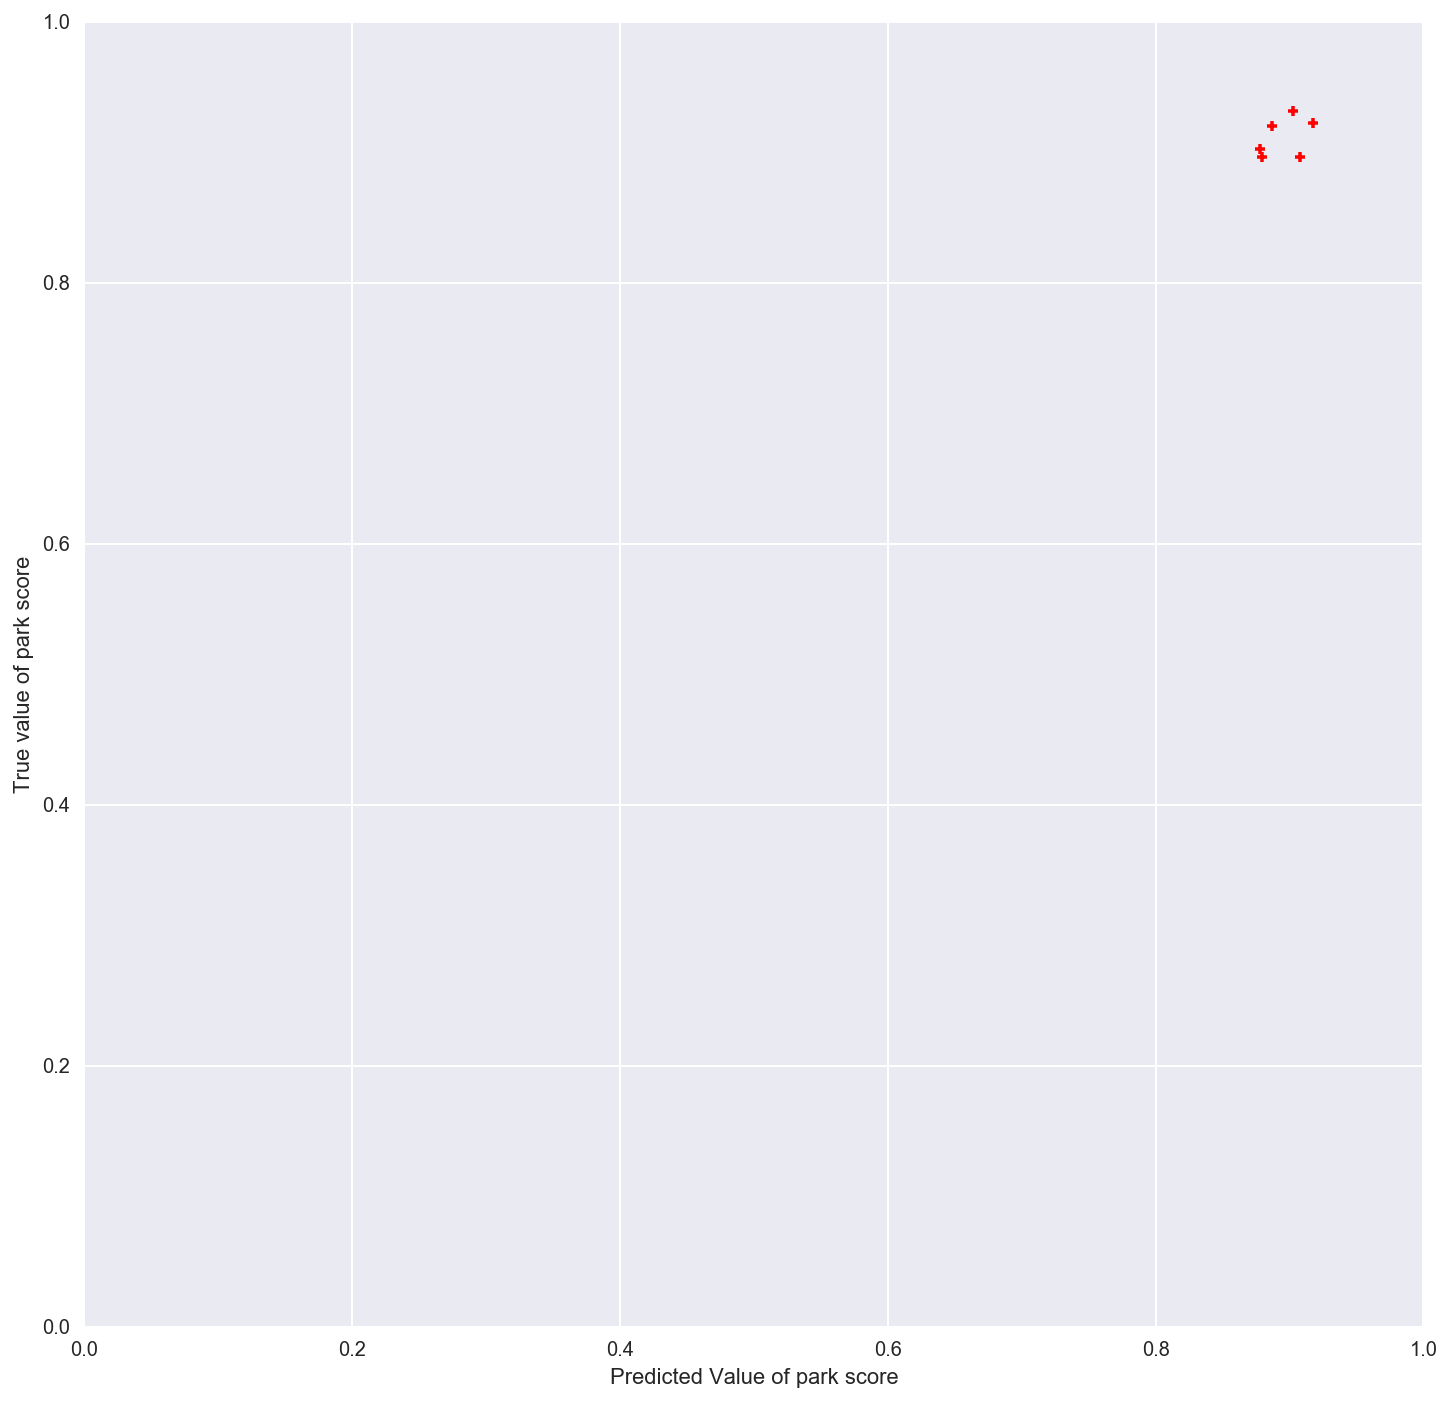

MSE: 
0.000501 



In [419]:
# Plot the model
plt.scatter(Y_hat_test, Y_test, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Value of park score")
plt.ylabel("True value of park score")
plt.ylim([0,1])
plt.xlim([0,1])
plt.show()

#Print characteristic values of your Linear regression:
print "MSE: \n%f \n" % mean_squared_error(Y_test, Y_hat_test)

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 5. Bias-variance tradeoff

---

1. Use a model from any of the previous questions above of your choice and construct a regularized regression model . Ideally the model should actually improve across regularization strengths...
- Gridsearch the regularization parameters to find the optimal.
- Plot the regularization parameter against the cross-validated $R^2$.
- Explain how regularization and regularization strength is related to the bias-variance tradeoff.


<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 5.1 Calculate the approximated $\text{bias}^2$ and variance across regularization strengths.

---

You can obviously use my code from the bias-variance lab to do this. 

Plot the bias and variance change _with_ the cross-validated $R^2$. 

You'll need to scale these values somehow to put them on the same chart (I recommend (MinMaxScaler)[http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html] to put $\text{bias}^2$ and variance on the same scale as cross-validated $R^2$.

<img src="http://imgur.com/HNPKfE8.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 6. Custom regularized regression penalties

---

The $\lambda1$ and $\lambda2$ norm regularization penalties (Lasso and Ridge) are the most commonly used regularization penalties. They have a solid foundation in statistics and evidence of effectiveness. However, these are not the only possible penalties for regression – sometimes new, customized penalties give additional performance and predictive power to models depending on the context.


**Devise of and implement a penalized regression for San Francisco Crime data.** What is your rationale – why would this be useful? How does it perform compared to the standard Ridge, Lasso, and Elastic Net penalties?

## Statistics, Biases, and Hypothesis Testing

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 7. Biases 

---
A new food ordering smartphone app incentivizes its users to invite their friends by offering them free orders for each friend that signs up
- What biases are being caused here?
 
- How would you measure the success of such a program?
  
- Rephrase this question to be unbiased:
    ** Many people have said that there is a need for stricter laws on dangerous weapons. Do you agree? ** 
   


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 8. Hypothesis Testing 

---

For the health/mortality data from the following website: 
http://assets.datacamp.com/blog_assets/chol.txt'


- Generate summary statistics, histogram plots, cdf plots, and confidence intervals for two columns of your choice and a correlation matrix across all
- Using what you generated, provide short summaries of each column describing the data
- Is there a difference in mortality between smokers, nonsmokers?
- If national average weight is 85 pounds, is our weight average significantly different?
- Until now, we’ve only asked is it different. This is called a two sided test. 
    - What if we want to know if its less than or greater than? This is called a one sided test. We can calculate this from the result of a two sided. You divide your p value in half and check if your t statistic is positive or negative Greater than: p/2 < confidence level and t > 0 and Less-than: p/2 < confidence level and t < 0.
    
    - If national average weight is 85 pounds, is our weight average statistical significantly less?

In [97]:
health = pd.read_csv('http://assets.datacamp.com/blog_assets/chol.txt', sep=" ")

In [98]:
health.describe()

,AGE,HEIGHT,WEIGHT,CHOL
count,200.000000,200.00000,200.000000,200.000000
mean,35.715000,172.35000,75.885000,233.600000
std,9.604426,6.77399,10.442076,44.766732
min,18.000000,156.00000,53.000000,107.000000
25%,28.750000,168.00000,68.750000,204.000000
50%,37.000000,172.00000,75.000000,232.000000
75%,42.000000,176.00000,82.000000,259.000000
max,58.000000,191.00000,110.000000,455.000000


In [99]:
smoke_dum = pd.get_dummies(health[['SMOKE', 'BLOOD']])

In [100]:
health = pd.concat([health,smoke_dum], axis=1)

In [101]:
health.corr()

,AGE,HEIGHT,WEIGHT,CHOL,SMOKE_nonsmo,SMOKE_pipe,SMOKE_sigare,BLOOD_a,BLOOD_ab,BLOOD_b,BLOOD_o
AGE,1.000000,-0.274894,0.053034,0.454691,-0.060716,0.010212,0.044086,-0.082376,0.024821,0.090522,0.016701
HEIGHT,-0.274894,1.000000,0.491970,-0.287539,-0.082843,0.033246,0.044356,0.060632,-0.088867,-0.013480,-0.023553
WEIGHT,0.053034,0.491970,1.000000,-0.034337,-0.014917,0.125905,-0.090098,0.027748,-0.087398,0.037634,-0.023651
CHOL,0.454691,-0.287539,-0.034337,1.000000,-0.100336,0.102209,0.003058,-0.054456,0.053072,0.024263,0.021901
SMOKE_nonsmo,-0.060716,-0.082843,-0.014917,-0.100336,1.000000,-0.293701,-0.623451,-0.025765,0.057709,0.096976,-0.053579
SMOKE_pipe,0.010212,0.033246,0.125905,0.102209,-0.293701,1.000000,-0.564272,-0.005491,-0.003931,-0.024325,0.021940
SMOKE_sigare,0.044086,0.044356,-0.090098,0.003058,-0.623451,-0.564272,1.000000,0.026744,-0.046626,-0.063860,0.028329
BLOOD_a,-0.082376,0.060632,0.027748,-0.054456,-0.025765,-0.005491,0.026744,1.000000,-0.133485,-0.293067,-0.761681
BLOOD_ab,0.024821,-0.088867,-0.087398,0.053072,0.057709,-0.003931,-0.046626,-0.133485,1.000000,-0.056295,-0.146310
BLOOD_b,0.090522,-0.013480,0.037634,0.024263,0.096976,-0.024325,-0.063860,-0.293067,-0.056295,1.000000,-0.321225


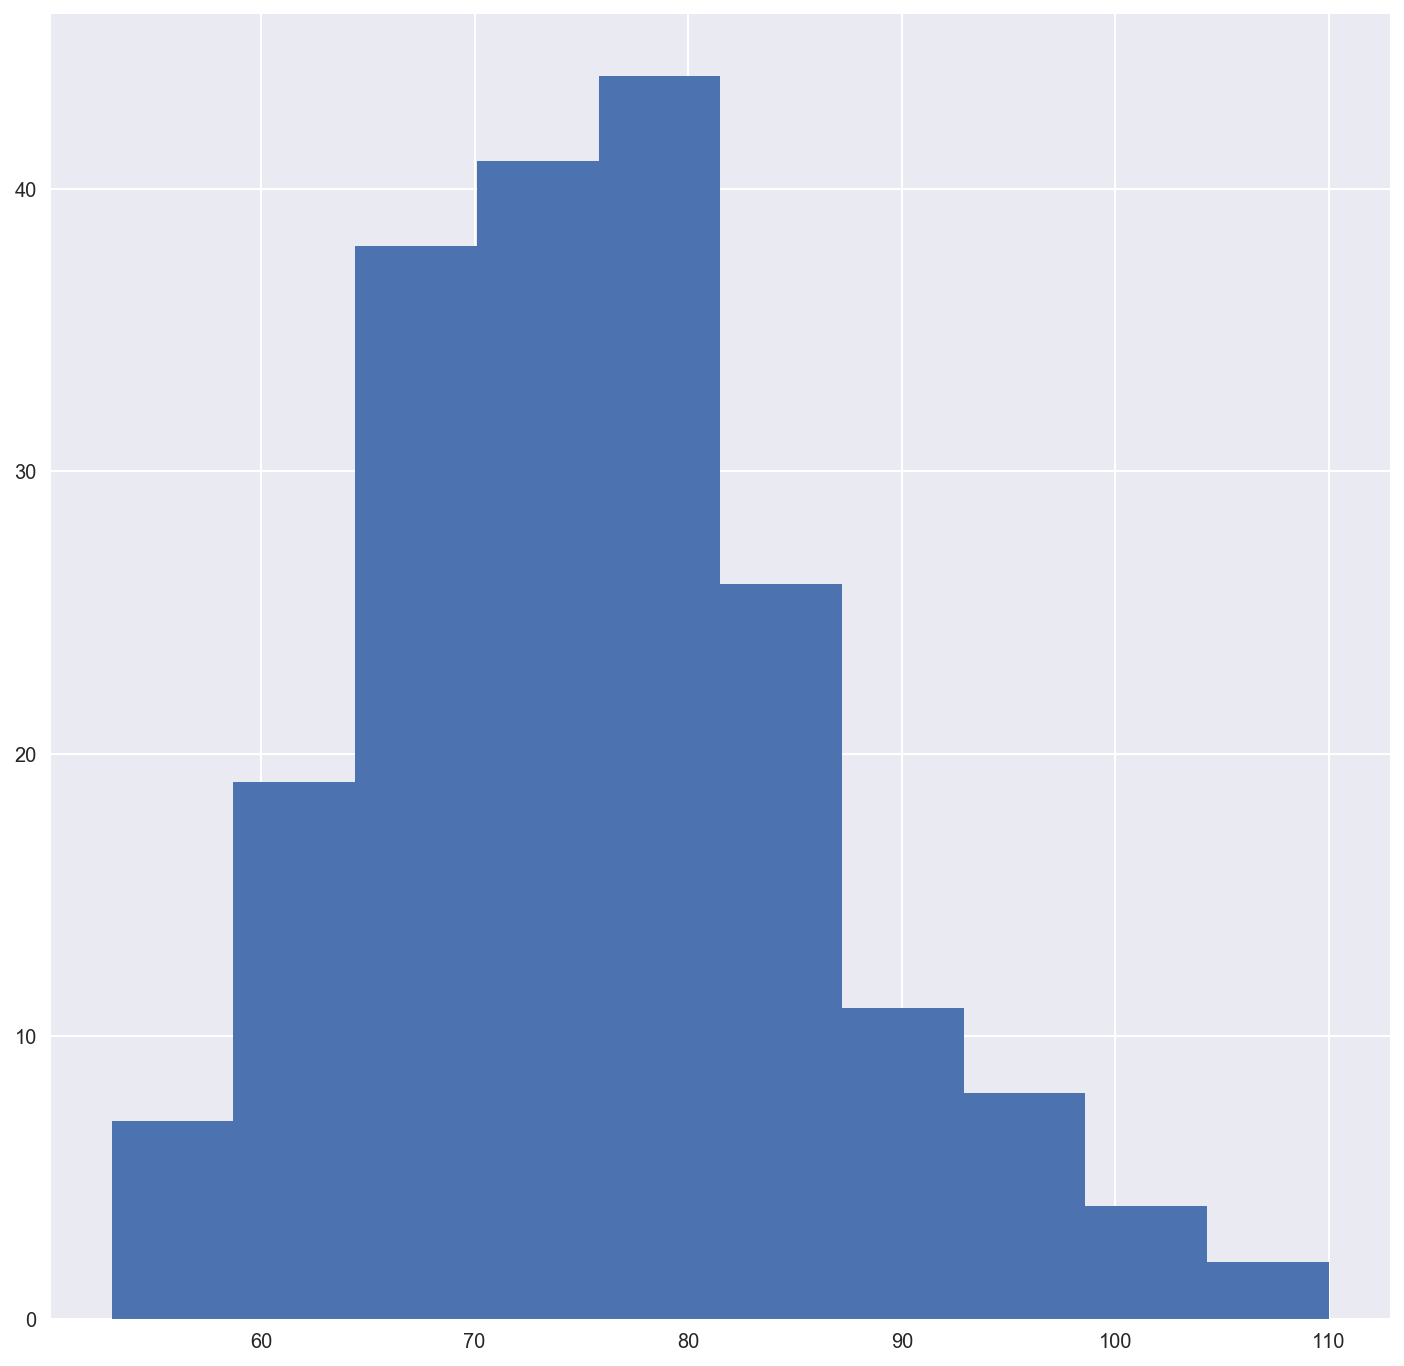

In [102]:
health.WEIGHT.hist()


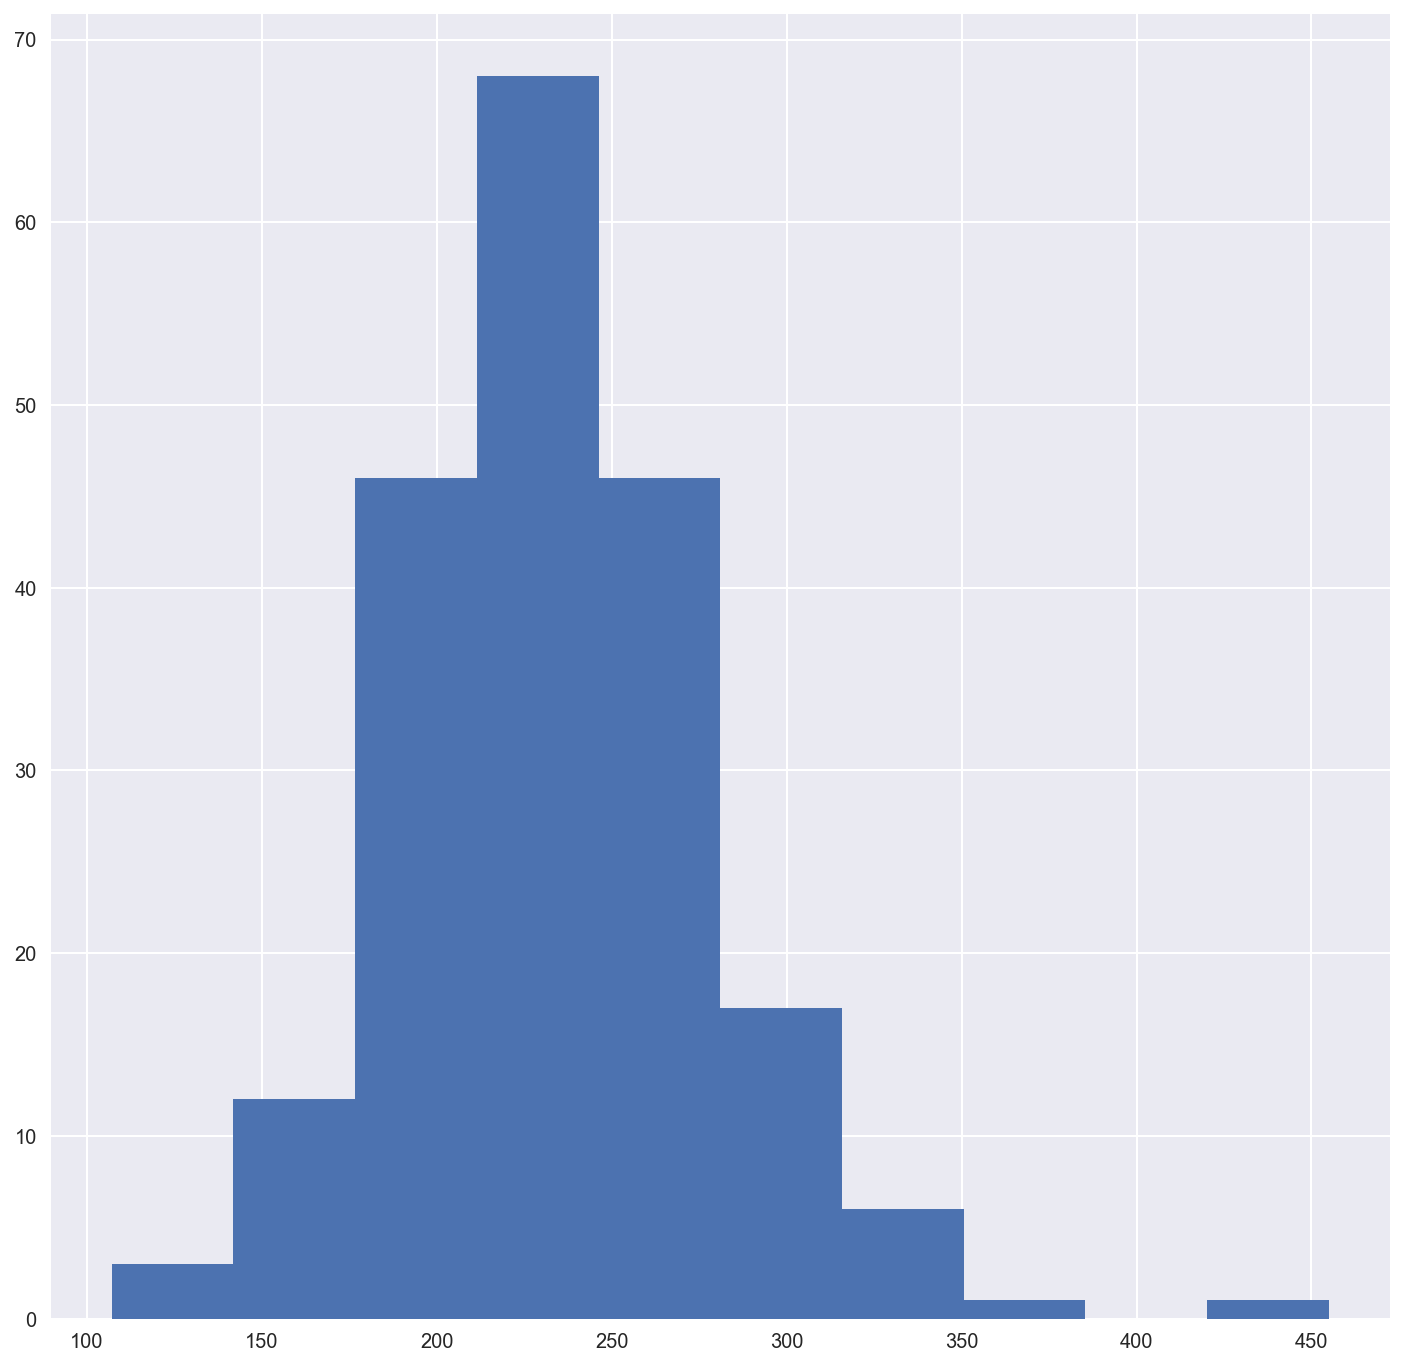

In [103]:
health.CHOL.hist()

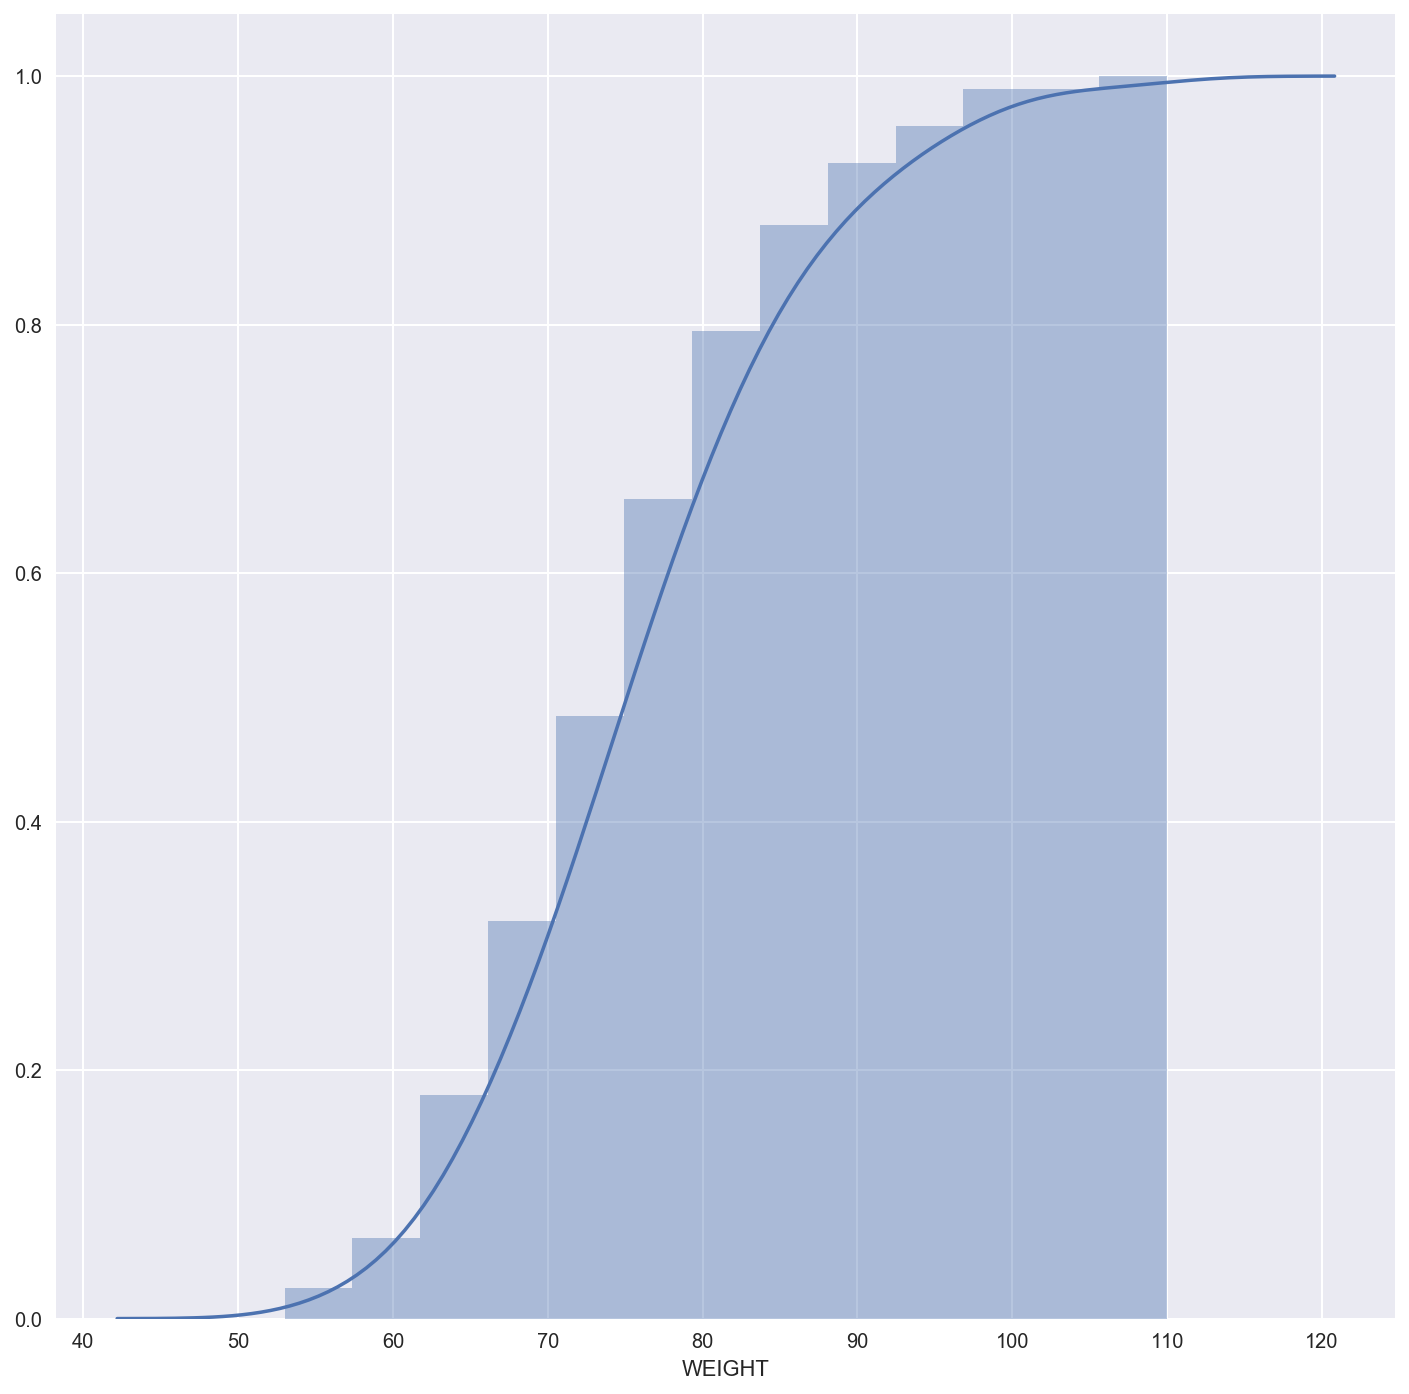

In [104]:
sns.distplot(health.WEIGHT,
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))

In [108]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return  m-h, m, m+h

In [109]:
mean_confidence_interval(health.CHOL)

(227.3577992004148, 233.59999999999999, 239.84220079958519)

In [110]:
mean_confidence_interval(health.WEIGHT)

(74.428973734623938, 75.885000000000005, 77.341026265376073)

In [112]:
health.head()

,AGE,HEIGHT,WEIGHT,CHOL,SMOKE,BLOOD,MORT,SMOKE_nonsmo,SMOKE_pipe,SMOKE_sigare,BLOOD_a,BLOOD_ab,BLOOD_b,BLOOD_o
0,20,176,77,195,nonsmo,b,alive,1,0,0,0,0,1,0
1,53,167,56,250,sigare,o,dead,0,0,1,0,0,0,1
2,44,170,80,304,sigare,a,dead,0,0,1,1,0,0,0
3,37,173,89,178,nonsmo,o,alive,1,0,0,0,0,0,1
4,26,170,71,206,sigare,o,alive,0,0,1,0,0,0,1


In [117]:
health.MORT = health.MORT.replace(('alive', 'dead'), (1,0))

In [118]:
health.groupby(['SMOKE'])['MORT'].mean()

SMOKE
nonsmo    0.918367
pipe      0.904762
sigare    0.853211
Name: MORT, dtype: float64

In [120]:
from scipy.stats import ttest_ind

non_sm = health[health['SMOKE']=='nonsmo']
sm = health[health['SMOKE']!='nonsmo']

ttest_ind(non_sm['MORT'], sm['MORT'], equal_var=False)

Ttest_indResult(statistic=1.053253450195184, pvalue=0.29478845575705775)

In [121]:
from scipy.stats import ttest_1samp

weight = health["WEIGHT"]

ttest_1samp(weight, 85)


Ttest_1sampResult(statistic=-12.344821194685455, pvalue=2.2901936138582111e-26)